In [24]:
#1、如何基于图片生成patch embedding (本质为path merging)
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

#patch embedding ⭐
'''
基于pytorch unflod的API来将图片[bs*channel*h*w]进行分块,也就是模仿卷积的思路,设置kernel_size=patch_size得到分块后的图片
得到格式为[bs,num_patch,patch_depth]
将张量与形状为[patch_depth,model_dim_c]的权重矩阵进行乘法操作，得到形状为[bs,num_patch,model_dim_c]的patch embedding
'''

# def image2emb_naive(image,patch_size,weight):
#     #image shape: [bs*channel*h*w]
#     patch = F.unfold(image,kernel_size=(patch_size,patch_size),
#                      stride=(patch_size,patch_size)).transpose(-1,-2)
#     print("patch=",patch.shape)
#     patch_embedding = patch @ weight
#     return patch_embedding

def Patch_Partition(image_size,patch_size):
    #image shape: [bs*channel*h*w]
    patch = F.unfold(image_size,kernel_size=(patch_size,patch_size),
                     stride=(patch_size,patch_size)).transpose(-1,-2)
    print(patch.shape)
    return patch

img = torch.rand(1,3,224,224)
patch_size = 4
weight = torch.rand(48,512)
Patch_Partition(img,patch_size).shape

def Linear_Embedding(patch,out_channel):
    size = patch.shape

torch.Size([1, 3136, 48])


torch.Size([1, 3136, 48])

In [21]:
#例子 假设有一张(1,4,4)  patch_size=2
batch_size = 1
patch_size = 2
in_channel = 1
h,w = (4,4)
channel = 2
img = torch.rand(batch_size,in_channel,h,w)
weight = torch.rand(4,2)
data = image2emb_naive(img,patch_size,weight)
data = data.reshape(batch_size,patch_size,patch_size,channel)
data.shape

patch= torch.Size([1, 4, 4])


torch.Size([1, 2, 2, 2])

In [ ]:
#2、如何构建MHSA并计算其复杂度
'''
基于输入x进行三个映射分别得到q,k,v
'''

class Multiheadselfattention(nn.Module):
    def __init__(self,model_dim,num_head):
        super().__init__()
        self.num_head = num_head

        self.proj_linear_layer = nn.Linear(model_dim,3*model_dim)
        self.final_linear_layer = nn.Linear(model_dim,model_dim)
    
    def forward(self,input,additive_mask = None):
        bs,seqlen,model_dim = input.shaape
        num_head = self.num_head
        head_dim = model_dim // num_head

        proj_output = self.proj_linear_layer(input)
        q,k,v = proj_output.chunk(3,dim=-1)   #[bs.seqlen,model_dim]

        q = q.reshape(bs,seqlen,num_head,head_dim).transpose(1,2)  #[bs,num_head,seqlen,head_dim]
        q = q.reshape(bs*num_head,seqlen,head_dim)

        k = k.reshape(bs,seqlen,num_head,head_dim).transpose(1,2)  #[bs,num_head,seqlen,head_dim]
        k = k.reshape(bs*num_head,seqlen,head_dim)

        v = v.reshape(bs,seqlen,num_head,head_dim).transpose(1,2)  #[bs,num_head,seqlen,head_dim]
        v = v.reshape(bs*num_head,seqlen,head_dim)

        if additive_mask is None:
            attn_prob = F.softmax(torch.bmm(q,k.transpose(-2,-1))/math.sqrt(head_dim),dim=-1)
        else:
            additive_mask = additive_mask.tile((num_head,1,1))
            attn_prob = F.softmax(torch.bmm(q,k.transpose(-2,-1))/math.sqrt(head_dim)+additive_mask,dim=-1)
        
        output = torch.bmm(attn_prob,v)
        output = output.reshape(bs,num_head,seqlen,head_dim).transpose(1,2)
        output = output.reshape(bs,seqlen,model_dim)

In [ ]:
#3、如何构建window MHSA并计算其复杂度
'''
将patch组成的图片进一步划分成一个个更大的window
在每个window内部计算MHSA
'''
def window_multi_head_self_attention(patch_embedding,mhsa,window_size=4,num_head=2):
    num_patch_in_window = window_size * window_size
    bs,num_patch,patch_depth = patch_embedding.shape
    image_height = image_width = int(math.sqrt(num_patch))

    patch_embedding = patch_embedding.transpose(-1,-2)   
    patch  = patch_embedding.reshape(bs,patch_depth,image_height,image_width)
    window = F.fold(patch,kernel_size=(window_size,window_size),stride=(window_size,window_size)).transpose(-1,-2)  #[bs,num_window,window_depth]

    bs,num_window,patch_depth_times_num_patch_in_window = window.shape
    window = window.reshape(bs*num_window,patch_depth,num_patch_in_window).transpose(-1,-2) #[bs*num_w,num_patch_in_window,patch_depth]

    attn_prob,output = mhsa(window) #output[bs*num_window,num_patch_in_window,patch_depth]

    output = output.reshape(bs,num_window,num_patch_in_window,patch_depth)

    return output


    

In [34]:
#类别矩阵
a  = torch.randint(low=0,high=4,size=(6,1))
a-a.T==0

tensor([[ True,  True, False, False, False,  True],
        [ True,  True, False, False, False,  True],
        [False, False,  True,  True,  True, False],
        [False, False,  True,  True,  True, False],
        [False, False,  True,  True,  True, False],
        [ True,  True, False, False, False,  True]])

In [ ]:
#4

In [ ]:
#定义辅助函数，window2image,将transformer block的结果转化成图片的格式
def window2image(msa_output):
    bs,num_window,num_patch_in_window,patch_depth = msa_output.shape
    window_size = int(math.sqrt(num_patch_in_window))
    image_height = int(math.sqrt(num_window)) * window_size
    image_width = image_height

    msa_output = msa_output.reshape(bs,
                                    int(math.sqrt(num_window)),
                                    int(math.sqrt(num_window)),
                                    window_size,
                                    window_size,
                                    patch_depth)
    
    msa_output = msa_output.transpose(2,3)
    image = msa_output.reshape(bs,image_height*image_width,patch_depth) 

    image = image.transpose(-1,-2).reshape(bs,patch_depth,image_height,image_width) #与卷积格式一样 [batch_size,channel,height,width]

    return image
    
#构建shift window multi-head attention mask
def build_mask_for_shifted_wmsa(batch_size,image_height,image_width,window_size):
    index_matrix = torch.zeros(image_height,image_width)

    for i in range(image_height):
        for j in range(image_width):
            row_times = (i+window_size//2)//window_size
            col_times = (j+window_size//2)//window_size
            index_matrix[i,j] = row_times*(image_height//window_size)+col_times+1
    rolled_index_matrix = torch.roll(index_matrix,shifts=(-window_size//2,-window_size//2),dims=(0,1))
    rolled_index_matrix = rolled_index_matrix.unsqueeze(0).unsqueeze(0)  #[bs,ch,h,w]

    c = c.tile(batch_size,1,1) #[bs,num_window,num_patch_in_window]

    bs,num_window,num_patch_in_window = c.shape

    c1 = c.unsqueeze(-1)
    
            

#定义辅助函数 shift_window,即高效地计算swmsa
def shift_window(w_msa_output,window_size,shift_size,generate_mask=False):
    bs,num_window,num_patch_in_window,patch_depth = w_msa_output.shape

    w_msa_output = window2image(w_msa_output)   #[bs,depth,h,w]
    bs,patch_depth,image_height,image_width = w_msa_output.shape

    rolled_w_msa_output = torch.roll(w_msa_output,shifts=(shift_size,shift_size),dims=(2,3))

    shifted_w_msa_input = rolled_w_msa_output.reshape(bs,patch_depth,int(math.sqrt(num_window)),
                                                      window_size,
                                                      int(math.sqrt(num_window)),
                                                      window_size)

    shifted_w_msa_input = shifted_w_msa_input.transpose(3,4)
    shifted_w_msa_input = shifted_w_msa_input.reshape(bs,patch_depth,num_window*num_patch_in_window)
    shifted_w_msa_input = shifted_w_msa_input.transpose(-1,-2)
    shifted_window = shifted_w_msa_input.reshape(bs,num_window,num_patch_in_window,patch_size)

    if generate_mask:
        additive_mask = bulid_mask_for_shifted_wmsa(bs,image_height,image_width,window_size)
    

In [ ]:
def shift_window_multi_head_self_attention(w_msa_output,mhsa,window_size=4,num_head=2):
    bs,num_window,num_patch_in_window,patch_depth = w_msa_output.shape
    shifted_w_msa_input,additive_mask = shift_window(w_msa_output,window_size,shift_size=-window_size//2,generate_mask=True)

tensor([[[[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],


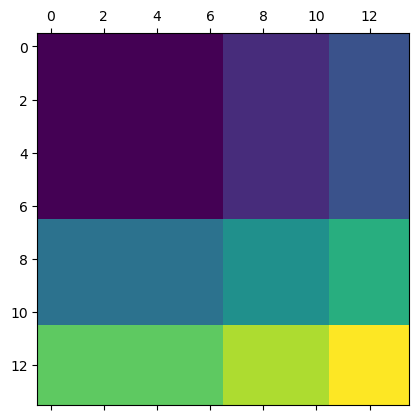

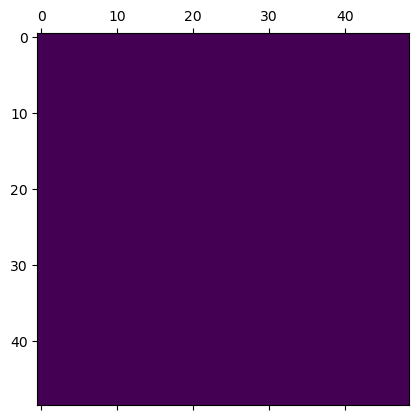

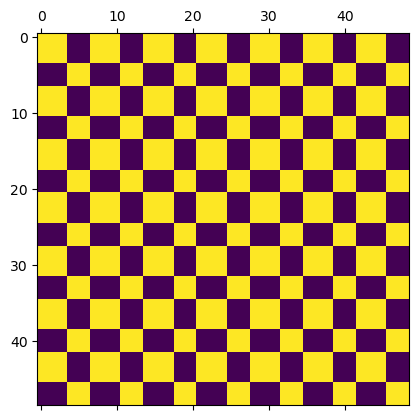

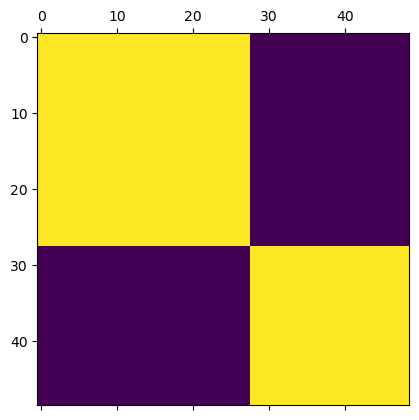

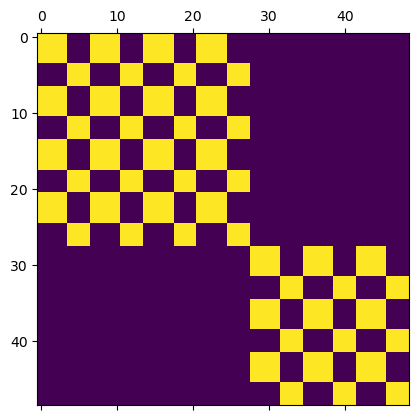

In [75]:
import torch

import matplotlib.pyplot as plt


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

window_size = 7
shift_size = 3
H, W = 14, 14
img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
h_slices = (slice(0, -window_size),            #[0,-7]
            slice(-window_size, -shift_size),  #[-7,-3]
            slice(-shift_size, None))          #[-3,0]
w_slices = (slice(0, -window_size),
            slice(-window_size, -shift_size),
            slice(-shift_size, None))
cnt = 0
for h in h_slices:
    for w in w_slices:
        img_mask[:, h, w, :] = cnt
        print(img_mask)
        cnt += 1

mask_windows = window_partition(img_mask, window_size)  # nW, window_size, window_size, 1
mask_windows = mask_windows.view(-1, window_size * window_size)

attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

plt.matshow(img_mask[0, :, :, 0].numpy())
plt.matshow(attn_mask[0].numpy())
plt.matshow(attn_mask[1].numpy())
plt.matshow(attn_mask[2].numpy())
plt.matshow(attn_mask[3].numpy())

plt.show()